# Predicting one-dimensional cellular automata

Preamble: Run the cells below to import the necessary Python packages

+ This notebook is modified from notebooks originally developed and used in [Pankaj Mehta's ML for physics course](http://physics.bu.edu/~pankajm/PY580.html) at Boston University. Please check out those notebooks and associated textbooks for additional details and exercises.

In [198]:
## Preamble / required packages
import numpy as np
np.random.seed(0)

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

import warnings
# Comment this out to activate warnings
warnings.filterwarnings('ignore')


# Supervised learning

+ Given an input $X$, construct a function that assigns it a label $\hat{y}$. 

+ **Regression:** $\hat{y}$ is a continuous variable. For example, given a picture of a person, predict their age. In physics, a common example is to predict the energy of a particle given its momentum, or forecast the next step in a time series.

+ **Classification:** $\hat{y}$ is a discrete variable. For example, given a picture of an animal, predict whether it is a cat or a dog. In physics, a common example is to predict whether a phase is ordered or disordered, or to detect whether a signal point is a background, signal, or anomaly.

The function $\hat{y} = f_\theta(X)$ is learned from many instances of labelled data comprising $X \in \mathbb{R}^{N_\text{data} \times N_\text{features}}$ and known $y \in \mathbb{R}^{N_\text{data}}$ pairs. The "weights" or parameters $\theta$ are adjusted during *training*.


<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/supervised_learning.gif" alt="supervised_learning" style="width: 750px;"/>


*Image from [source](https://github.com/ReiCHU31/Cat-Dog-Classification-Flask-App)*

## Supervised learning as inferring a generator

+ We can see supervised learning as the process of learning a *generator* for a dataset: given a set of points, can we approximate the underlying process that produced those points?
+ + Forecasting: given some past values, predict future values
+ + Regression: Given a known generator with unknown parameters (like a quadratic Hamiltonian with unknown amplitudes), infer those amplitudes
+ + Classification (most famous example in ML): Given examples of labelled images, states, etc, predict the class of unlabelled data. We can think of the learned decision boundary as defining a generator of new examples belonging to that class (see conditional GANs, etc)

### Load experimental measurements of an unknown spin chain

+ Suppose we have a spin chain with $L$ spins evolving in time

+ Our data consists of $N_\text{data}$ measurements of binary microstates $\mathbf{s} \in \{0,1\}^L$ corresponding to spins.

Text(0.5, 0, 'Time')

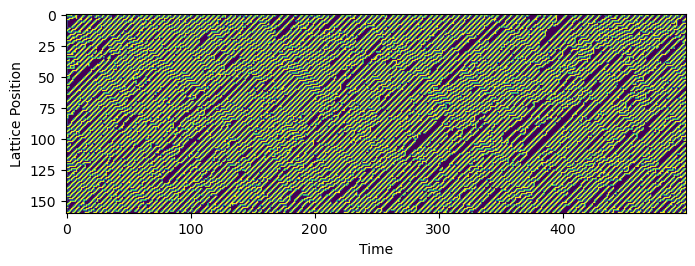

In [200]:
microstates = np.load('../resources/spin_chain_microstates.npy', allow_pickle=True)[:500]
plt.figure(figsize=(8, 8))
plt.imshow(microstates.T)
plt.ylabel("Lattice Position")
plt.xlabel("Time")

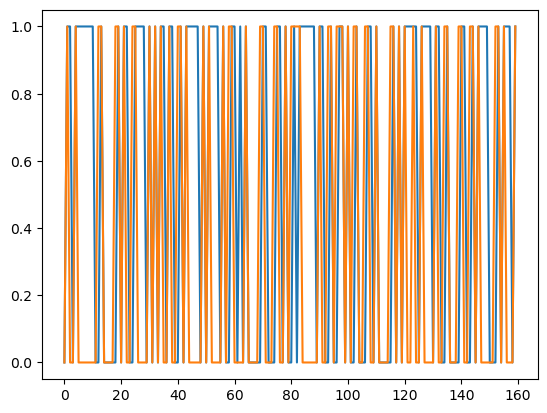

In [207]:
plt.plot(microstates[0])
plt.plot(microstates[1])

### Forecasting as a supervised learning problem

+ Looking at the data, we notice that the spins appear to exhibit temporal correlations: the state at time $t$ is correlated with the state at time $t-1$.

+ One hypothesis is that the spins are evolving according to Markovian dynamics, in which the state of the lattice at time $t$ is depends only the state at time $t-1$.

$$
\mathbf{s}_i = f(\mathbf{s}_{i-1})
$$

+ We don't know the form of $f$, but we can try to learn it from the data. In order to frame this as a supervised learning problem, we therefore think of each data point as a given spin configuration $\mathbf{s}_{i}$ and its label as the next spin configuration $\mathbf{s}_{i+1}$.

+ Note how this concept of supervised learning differs from image classification: here, the label is not a single number, like an integer or a class label, but an entire vector with shape equal to the input data.

+ We will start by inspecting the data $\mathbf{s}_i$ and the regression target $\mathbf{s}_{i+1}$.

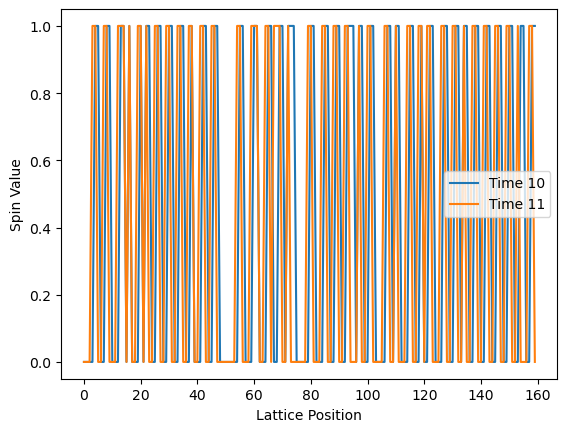

In [208]:
plt.plot(microstates[10], label="Time 10")
plt.plot(microstates[11], label="Time 11")
plt.xlabel("Lattice Position")
plt.ylabel("Spin Value")
plt.legend()

### Training and testing splits

+ In order to frame this problem as supervised learning, we need to split the data into training and testing sets. We will use the first 80% of the data for training and the last 20% for testing.

+ By convention, in supervised learning we refer to the input data as $X$ and the target as $y$. In this case, $X \in \mathbb{Z}^L$ will be the spins at time $t$ and $y \in \mathbb{Z}^L$ will be the spins at time $t+1$.

In [212]:
X_all, y_all = microstates.copy()[:-1], microstates.copy()[1:]
print("X_all shape: ", X_all.shape)
print("y_all shape: ", y_all.shape, "\n")


X_all shape:  (499, 160)
y_all shape:  (499, 160) 



In [214]:

# Data matrix / design matrix always has shape (n_samples, n_features)
X_train, X_test = X_all[:400], X_all[400:]
y_train, y_test = y_all[:400], y_all[400:]
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape, "\n")
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)


X_train shape:  (400, 160)
y_train shape:  (400, 160) 

X_test shape:  (99, 160)
y_test shape:  (99, 160)


### A note on flattening

+ For our problem, the input data is a binary vector $\mathbf{s}(t)$ of length $L$, and the target is a binary vector $\mathbf{s}(t+1)$ of length $L$. Our training dataset $X \in \mathbb{N_\text{data} \times L}$ has the typical form of a supervised learning dataset.

+ However, if we had a multidimensional dataset, we would need to flatten it into a 1D vector. For example, if we were studying the 2D, each snapshot of the system would be an $L \times L$ matrix, and we might have $N_\text{data}$ snapshots. Our training data would then be $X \in \mathbb{R}^{N_\text{data} \times L \times L}$, and we would need to flatten it into a 1D vector $X \in \mathbb{R}^{N_\text{data} \times L^2}$.


# Fitting a linear model with least squares

+ What is the simplest function we can think of that maps a vector $\mathbf{s}_{i} \in \mathbb{R}^{L}$ to another vector $\mathbf{s}_{i+1} \in \mathbb{R}^{L}$? Recall that the linear model is defined as
  $$
    \mathbf{s}_{i + 1} = A \cdot \mathbf{s}_{i}
  $$
  where $A \in \mathbb{R}^{L \times L}$. 

+ In our case, the features are the current state matrices $\mathbf{y}_{i}$, and the predictions are the subsequent microstate matrics $\mathbf{y}_{i+1}$. We therefore view linear regression as a data-driven method for learning a Markovian dynamical system that evolves the spins in time.

+ Given a dataset $\mathbf{X} \in \mathbb{R}^{N_\text{data} \times L}$ and regression target $\mathbf{y} \in \mathbb{R}^{N_\text{data} \times L}$, we can use the least squares method to find the matrix $A$ that best fits the data. The least squares solution is given by
  $$
    A = \left( \mathbf{X}^T \mathbf{X} \right)^{-1} \mathbf{X}^T \mathbf{y}
  $$
  This is called the Moore-Penrose pseudoinverse because the matrix $\mathbf{X}^T \mathbf{X}$ is not square, and so we can't directly invert it. Instead, the matrix $\left( \mathbf{X}^T \mathbf{X} \right)^{-1} \mathbf{X}^T$ minimizes the squared error between the predicted $\hat{\mathbf{s}}_{i+1}$ for each $\mathbf{s}_i$ and the true $\mathbf{s}_{i+1}$.

+ The best-fit predictions of the trained model are given by
  $$
    \mathbf{\hat{s}}_{i + 1} = A \cdot \mathbf{s}_{i}
  $$
  Usually, in supervised learning we generically use $\mathbf{\hat{y}}$ to denote the predictions of the model, and $\mathbf{y}$ to denote the true labels, and $\mathbf{X}$ to denote the input data. So we can also write the generic form of prediction as $\mathbf{\hat{y}} = A \cdot \mathbf{X}$.
  
### Python syntax: the `scikit-learn` library

+ Rather than using `numpy`, we will use the Python machine learning library `scikit-learn` to perform the linear regression. 

+ `scikit-learn` uses a consistent API for both simple models, like linear regression, and more complex models, like neural networks. Machine learning models are objects that are first instantiated with all hyperparameters, then trained on data using the `fit` method to determine the values of all parameters ($A$ in our case), and finally used to make predictions (here denoted $\mathbf{\hat{s}}_{i+1}$ or $\mathbf{\hat{y}}$) using the `predict` method.



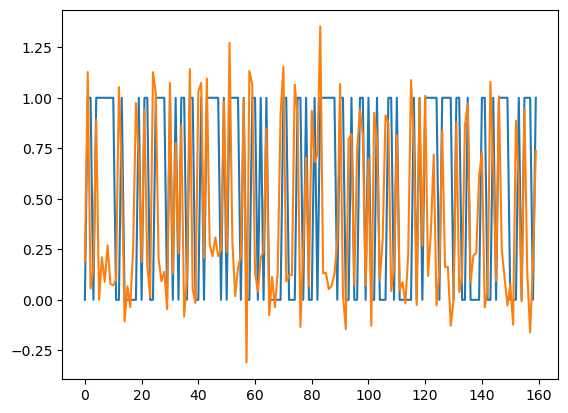

In [221]:
from sklearn.linear_model import LinearRegression#, RidgeCV, Lasso

# model = RidgeCV()
# model = Lasso(alpha=6e-2)
model = LinearRegression()

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)

# plt.imshow(model.coef_)

plt.plot(X_train[0])
# plt.plot(y_train[0])
plt.plot(y_pred_train[0])

Text(0.5, 1.0, 'Difference between true and predicted values')

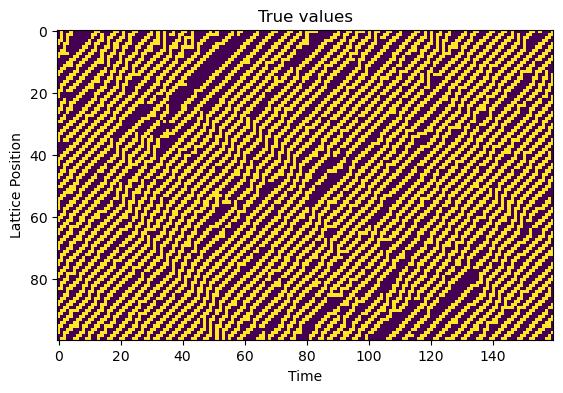

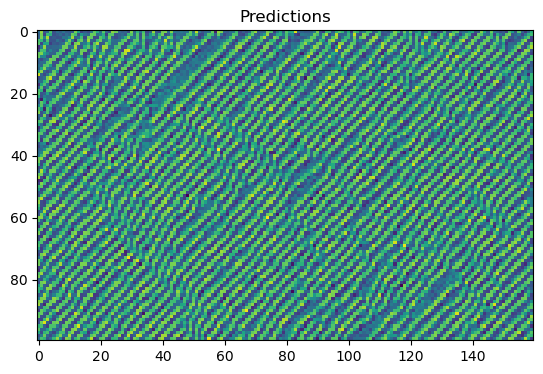

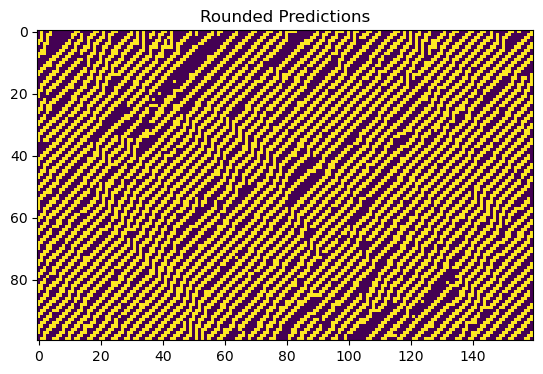

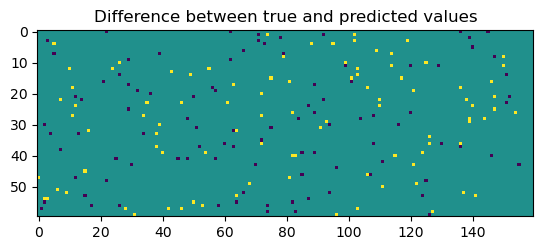

In [225]:
plt.figure()
plt.imshow(y_train[:100])
plt.xlabel("Time")
plt.ylabel("Lattice Position")
plt.title("True values")

plt.figure()
plt.imshow(y_pred_train[:100])
plt.title("Predictions")

plt.figure()
plt.imshow(np.round(y_pred_train[:100]))
plt.title("Rounded Predictions")

plt.figure()
plt.imshow(y_train[-60:] - np.round(y_pred_train[-60:]))
plt.title("Difference between true and predicted values")

# plt.colorbar()

### Scoring a regression model

We will use the $R^2$ score to evaluate the performance of our model. The $R^2$ score is defined as
$$
R^2 = 1 - \frac{\sum_i (\mathbf{y}_i - \hat{\mathbf{y}}_i)^2}{\sum_i (\mathbf{y}_i - \bar{\mathbf{y}})^2}
$$
where $i$ indexes datapoints, $\mathbf{y}_i$ are the true regression targets, $\hat{\mathbf{y}}_i$ are the predicted values, and $\bar{\mathbf{y}}$ is the elementwise mean of the true values. The $R^2$ score is a measure of how well the model explains the variance in the data. A score of 1 indicates a perfect fit, while a score of 0 indicates that the model is no better than predicting the mean of the data. 

In [226]:
def coefficient_of_determination(y_true, y_pred):
    """The R^2 score, or coefficient of determination, is a measure of how well 
    future samples are likely to be predicted by the model.
    
    Args:
        y_true (np.ndarray): True values
        y_pred (np.ndarray): Predicted values

    Returns:
        float: R^2 score
    """
    ss_res = np.sum((y_true - y_pred) ** 2)  # Sum of squared residuals
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)  # Total sum of squares
    r2 = 1 - (ss_res / ss_tot)
    return r2

print("R^2 score on training data: ", coefficient_of_determination(y_train, y_pred_train))

R^2 score on training data:  0.8526570213563216


#### What about experiments that the model hasn't seen before?  

+ The test set corresponds to the pairs of $X$ and $y$ that the model hasn't seen before, which here correspond to pairs of successive spin configurations that the model hasn't seen before.

+ We use the test set to evaluate the model's performance on unseen data. If the model performs well on the test set, we can be more confident that it learned general features of the data, rather than just memorizing the training set.

Text(0.5, 1.0, 'Difference between true and predicted values')

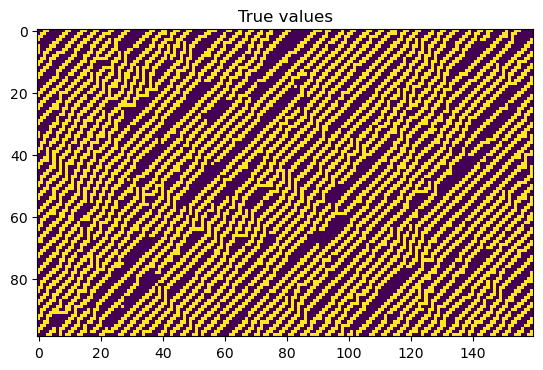

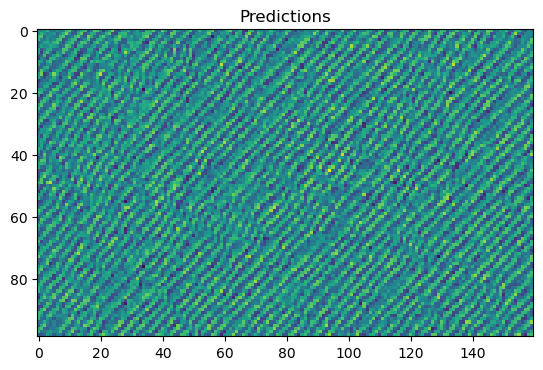

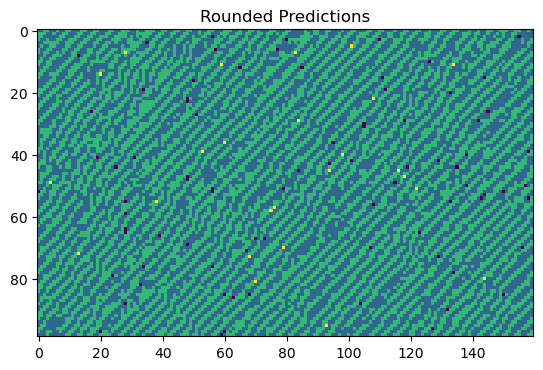

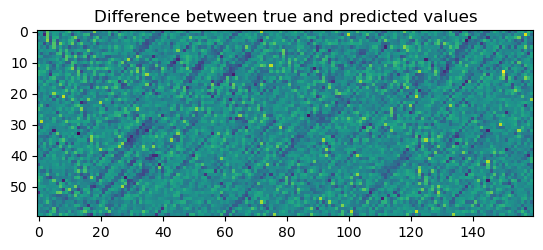

In [232]:
y_pred_test = model.predict(X_test)

plt.figure()
plt.imshow(y_test[:100])
plt.title("True values")

plt.figure()
plt.imshow(y_pred_test[:100])
plt.title("Predictions")

plt.figure()
plt.imshow(np.round(y_pred_test[:100]))
plt.title("Rounded Predictions")

plt.figure()
plt.imshow(y_test[-60:] - y_pred_test[-60:])
plt.title("Difference between true and predicted values")


In [233]:
print("R^2 score on test data: ", coefficient_of_determination(y_test, y_pred_test))

R^2 score on test data:  0.5461927695908562


### Overfitting
+ High train accuracy just tells us that our model class is capable of expressing patterns found the training data

+ For all datasets, there exists a way to get 100% train accuracy as long as I have access to memory equal to the size of the training dataset (1-nearest-neighbor lookup table)

+ We therefore need to either regularize (training data can't be perfectly fit) or use a test dataset to see how good our model actually is

+ A reasonable heuristic when choosing model complexity is to find one that can just barely overfit train (suggests sufficient power)

## But raw score doesn't tell the whole story

+ We can get a great fit, but our model might have a lot of free parameters
+ There might be multiple valid coupling matrices $J$ that explain the observed data
+ Our model might be predictive but not interpretable, or physical
+ We either need more data, better data (sample rarer states), or a better model


#### Let's look at the learned coupling matrix, or the weights of our fitted model

+ These store the "physics" that our model learned from the data

+ Recall that the number of trainable parameters is $L^2$, where $L$ is the number of spins in the chain. We had $L=160$ spins, so we have ~$25,000$ parameters to learn.

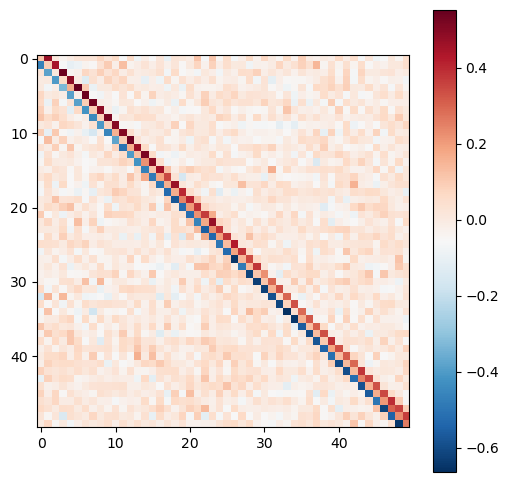

In [236]:
## Because we flattened the data, we need to reshape the coefficients to get the couplings
L = X_train.shape[1]
rules_estimated = np.array(model.coef_)

plt.figure(figsize=(6, 6))
plt.imshow(rules_estimated[:50, :50], cmap='RdBu_r')
plt.colorbar()

#### Let's try repeating the model fitting several times on different subsets of our experimental data

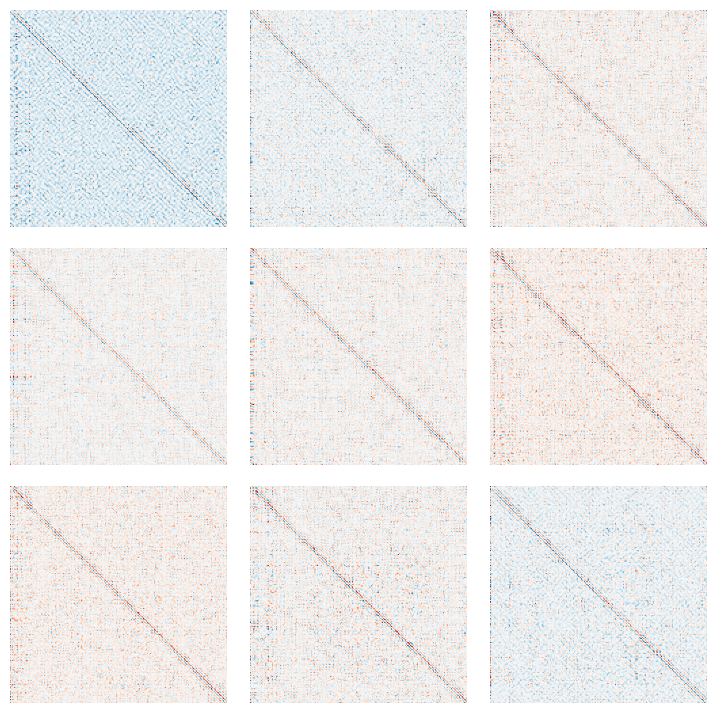

In [237]:
plt.figure(figsize=(9, 9))
## Plot 3 x 3 subplots

n_samples = 20
for i in range(9):

    ## Pick random training data set
    selection_inds = np.random.choice(range(X_train.shape[0]), size=n_samples, replace=False)
    X_train_subset, y_train_subset = X_all[selection_inds], y_all[selection_inds]
    model = LinearRegression()
    model.fit(X_train_subset, y_train_subset)
    rules_estimated = np.array(model.coef_)
    
    ## Plot learned coupling matrix
    plt.subplot(3, 3, i + 1)
    plt.imshow(rules_estimated, cmap='RdBu_r')
    plt.axis('off')

# spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)


#### We can see that there is *variance* in the fitted models. While they have some similarities, the fitted parameters (weights) vary from trained replicate to replicate

+ In machine learning, there are three ways to reduce the variance of a model: increase the amount of data (expensive), or constrain the model class to have fewer (or effectively fewer) free parameters, by introducing *bias* towards a particular solution.

# Narrowing the model class with regularization

+ We constrain the model's allowed space of valid representations in order to select for more parsimonious models

+ Operationally, regularizers/constraints reduce the "effective" number of parameters, and thus complexity, of our model

+ Imposing preferred basis functions or symmetries can be forms of regularization


### Ordinary linear regression solves an optimization problem

+ We can think of our least-squares problem as choosing the optimal $A$ that minimizes the following objective function, the mean squared error between the model predictions and true predictions
$$
\mathcal{L}_\text{MSE}(\mathbf{y}, \hat{\mathbf{y}}) = \frac{1}{N_\text{data}} \sum_{i=1}^{N_\text{data}} \left( \mathbf{y}_i - \hat{\mathbf{y}}_i \right)^2
$$

+ The ordinary least squares formula above minimizes this loss function for a given input dataset $X$ and paired targets $y$, under the constraint that the model is linear

### Regularization

+ Common regularizers add penalties to the loss function above, which can be thought of as limiting the space of allowed solutions. Instead of all $L^2$ parameters in the matrix $A$ being free to vary, the regularizer imposes constraints on the allowed values of the parameters.

+ **Ridge regression** (aka $L2$ regularization) discourages any particular weight in the coefficient matrix from becoming too large. Ridge imposes a degree of smoothness or regularity across how a model treats its various inputs. Models that take continuous data as inputs (such as time series, or images), may benefit from the ridge term.

$$
\mathcal{L}_\text{Ridge}(\mathbf{y}, \hat{\mathbf{y}}) = \frac{1}{N_\text{data}} \sum_{i=1}^{N_\text{data}} \left( \mathbf{y}_i - \hat{\mathbf{y}}_i \right)^2 + \lambda \sum_{i,j} A_{ij}^2
$$

+ **Lasso** is also known as $L1$ regularization, and it encourages *sparsity* in weight space: it incentivizes models were most coefficients go to zero, thereby reducing the models dependencies on features. Lasso is often used in feature selection, where we want to identify the most important features in a dataset.

$$
\mathcal{L}_\text{Lasso}(\mathbf{y}, \hat{\mathbf{y}}) = \frac{1}{N_\text{data}} \sum_{i=1}^{N_\text{data}} \left( \mathbf{y}_i - \hat{\mathbf{y}}_i \right)^2 + \lambda \sum_{i,j} |A_{ij}|
$$

Both of these penalties introduce a hyperparameter, $\lambda$, that controls the strength of the regularization. When $\lambda = 0$, the regularized loss function reduces to the ordinary least squares loss function. As $\lambda$ increases, the regularizer becomes more important relative to the data loss term, and the model is more constrained.



Let's try re-fitting the model with these different regularizers. We will vary $\lambda$, the strength of the regularization, and see how the learned dynamical system changes

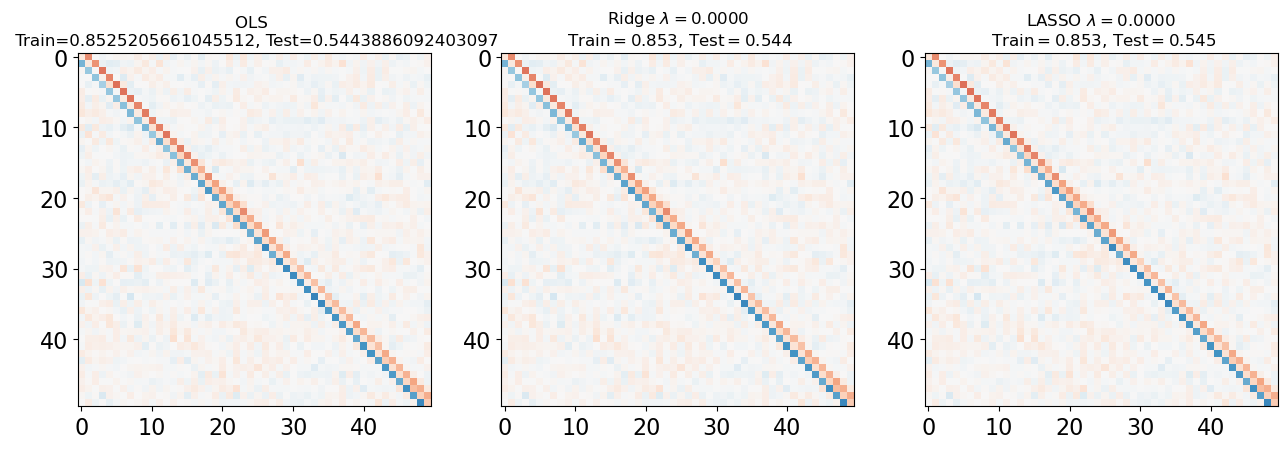

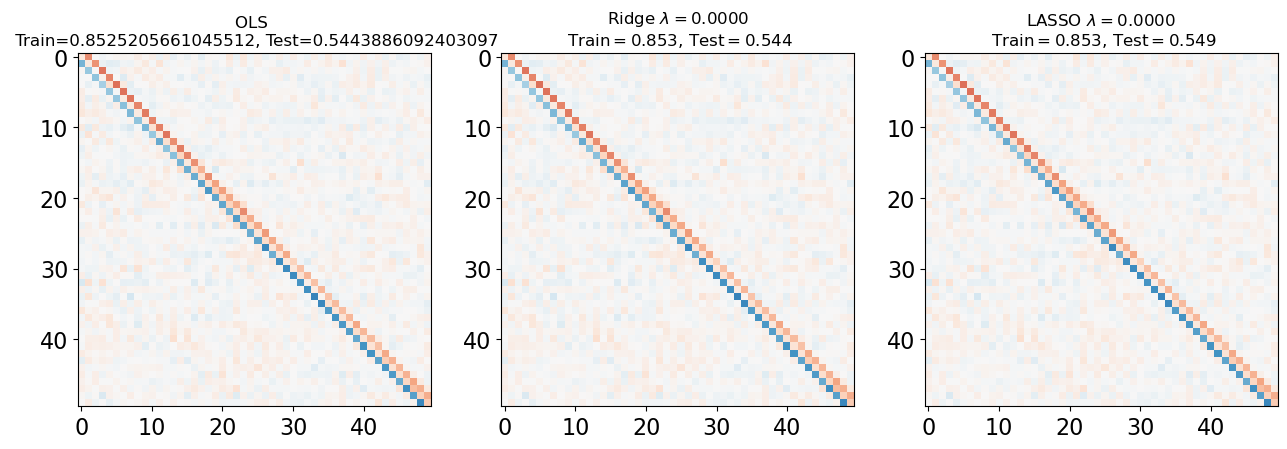

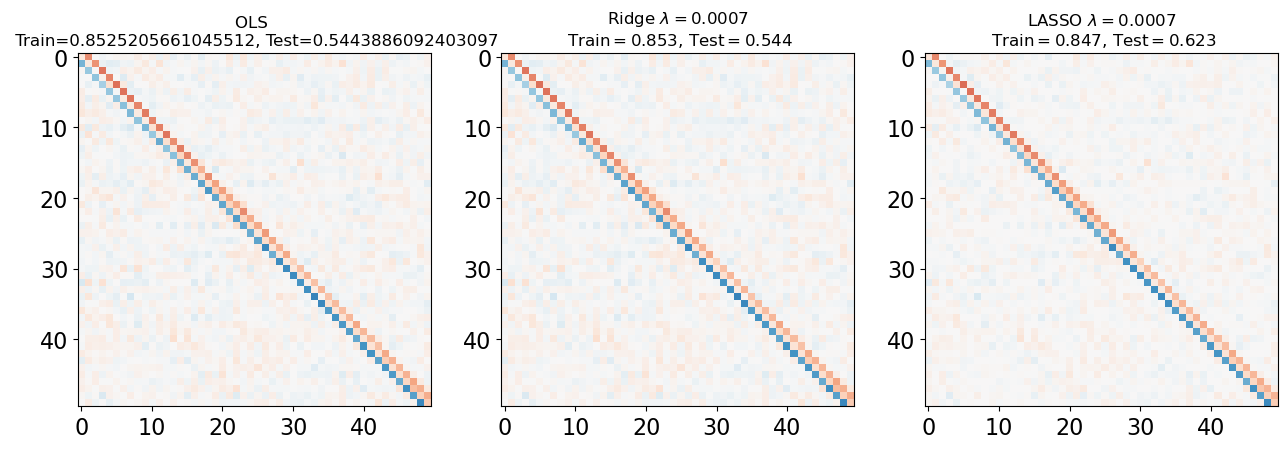

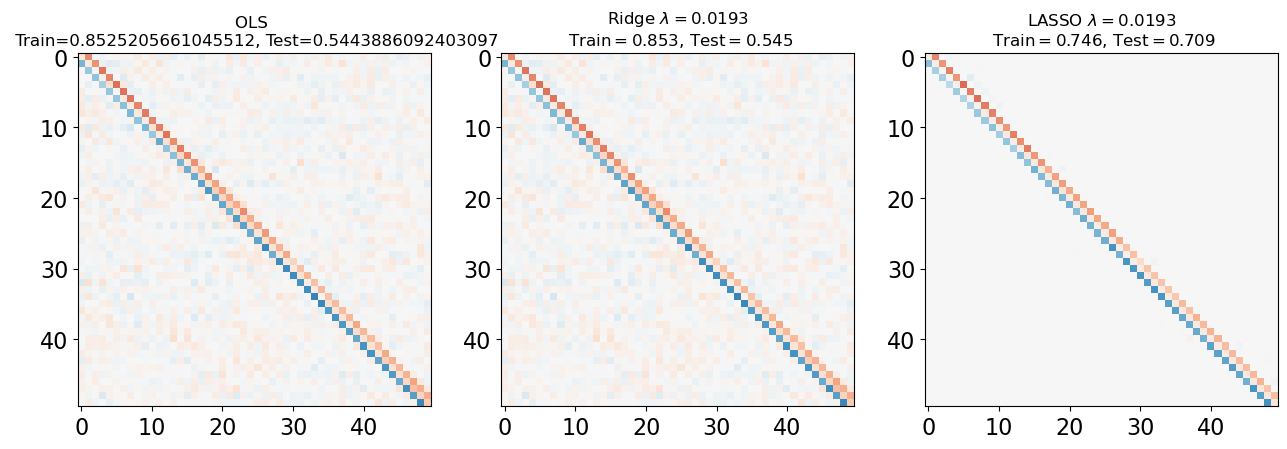

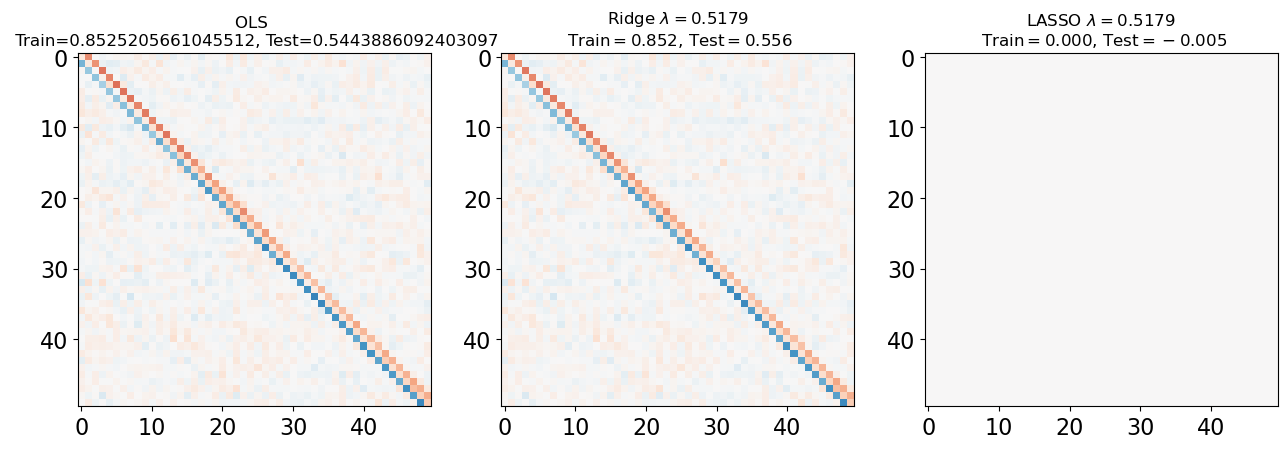

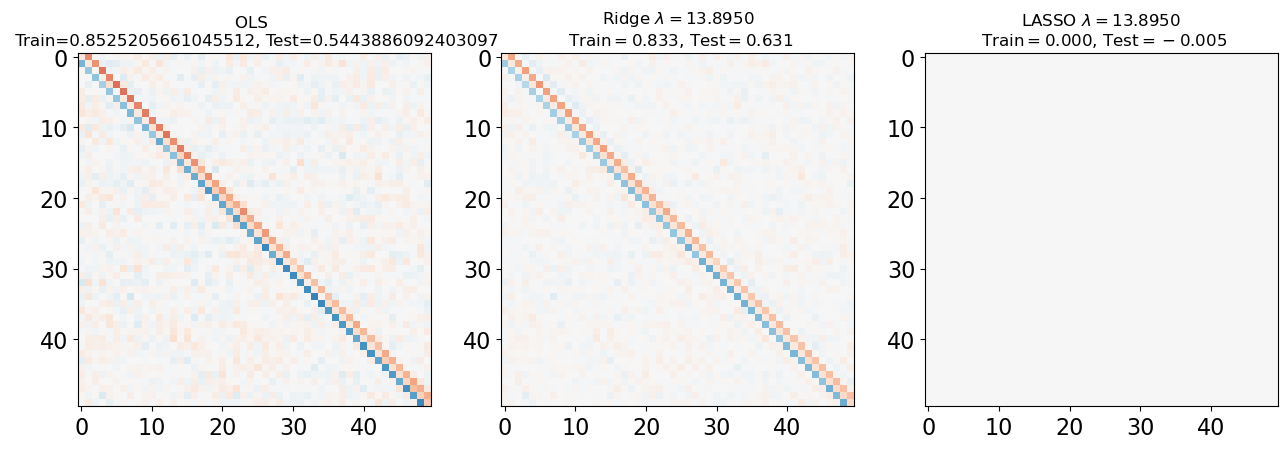

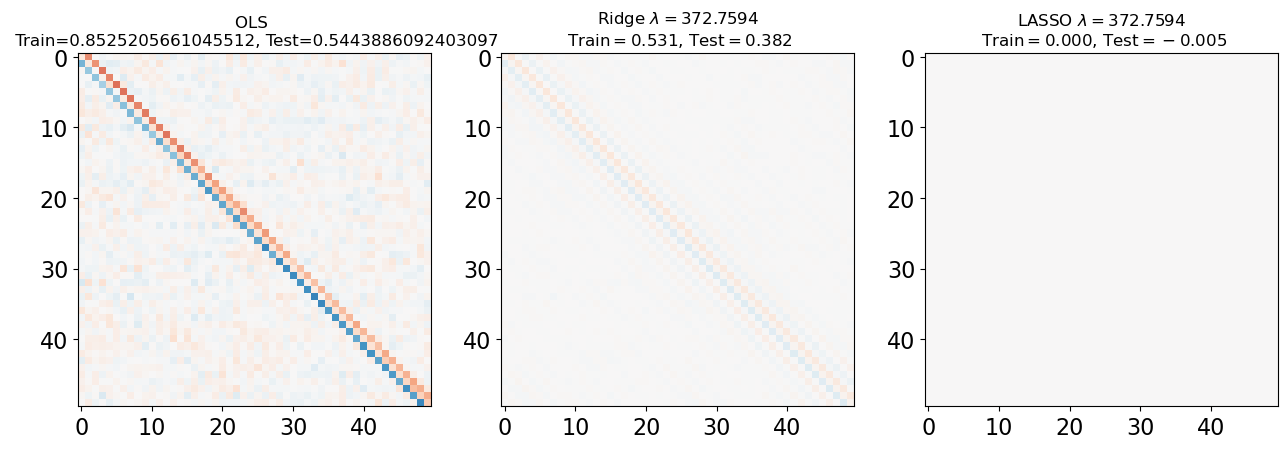

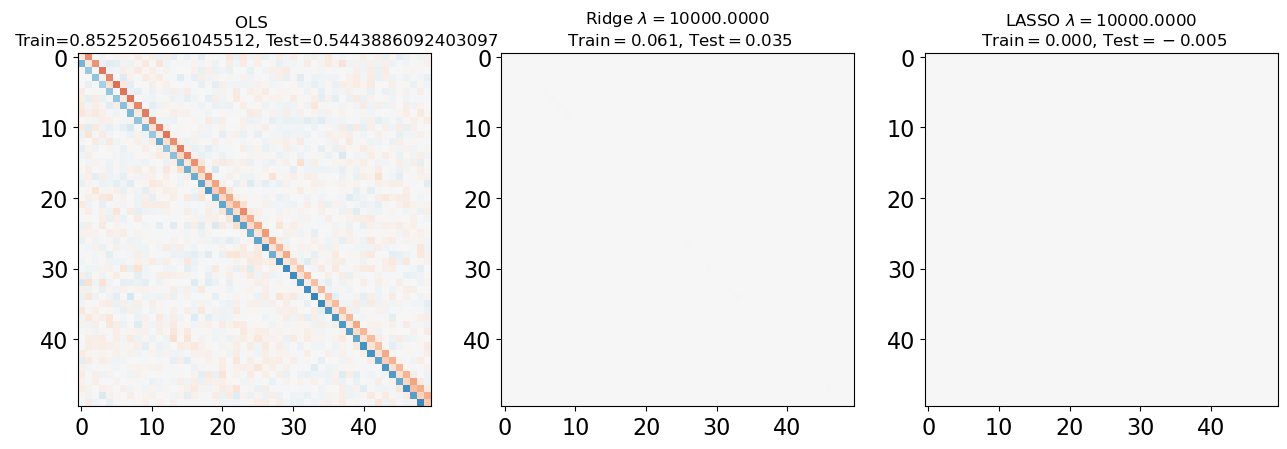

In [238]:


# Instantiate models
from sklearn import linear_model
model_ols = linear_model.LinearRegression()
model_l2 = linear_model.Ridge()
model_l1= linear_model.Lasso()

# Set regularization range
lambdas = np.logspace(-6, 4, 8)

# Load data
# define subset of samples
# n_samples = 100
X_train, X_test = X_all[:400], X_all[400:]
y_train, y_test = y_all[:400], y_all[400:]

# define error lists
train_error_ols, test_error_ols = list(), list()
train_error_l2, test_error_l2 = list(), list()
train_error_l1, test_error_l1 = list(), list()

#Initialize coefficients for ridge regression and Lasso
coeffs_ols, coeffs_ridge, coeffs_lasso = list(), list(), list()

for lam in lambdas:
    ### ordinary least squares
    model_ols.fit(X_train, y_train) # fit model 
    coeffs_ols.append(model_ols.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_error_ols.append(model_ols.score(X_train, y_train))
    test_error_ols.append(model_ols.score(X_test, y_test))

    ### ridge regression
    model_l2.set_params(alpha=lam) # set regularisation strength
    model_l2.fit(X_train, y_train) # fit model
    coeffs_ridge.append(model_l2.coef_) # store weights
    train_error_l2.append(model_l2.score(X_train, y_train))
    test_error_l2.append(model_l2.score(X_test, y_test))

    ### lasso
    model_l1.set_params(alpha=lam) # set regularisation strength
    model_l1.fit(X_train, y_train) # fit model
    coeffs_lasso.append(model_l1.coef_) # store weights
    train_error_l1.append(model_l1.score(X_train, y_train))
    test_error_l1.append(model_l1.score(X_test, y_test))




    ### plot Ising interaction J
    J_leastsq = np.array(model_ols.coef_).reshape((L, L))
    J_ridge = np.array(model_l2.coef_).reshape((L, L))
    J_lasso = np.array(model_l1.coef_).reshape((L, L))


    fig, axarr = plt.subplots(nrows=1, ncols=3)
    
    axarr[0].imshow(J_leastsq[:50, :50],  cmap="RdBu_r", vmin=-1, vmax=1)
    axarr[0].set_title(f"OLS \n Train={train_error_ols[-1]}, Test={test_error_ols[-1]}")
    ## 3 sig figs
    # axarr[0].set_title('OLS \n Train$=%.3f$, Test$=%.3f$' %(train_error_ols[-1],test_error_ols[-1]))
    axarr[1].set_title('OLS $\lambda=%.4f$\n Train$=%.3f$, Test$=%.3f$' %(lam, train_error_ols[-1],test_error_ols[-1]))
    axarr[0].tick_params(labelsize=16)
    
    axarr[1].imshow(J_ridge[:50, :50],  cmap="RdBu_r", vmin=-1, vmax=1)
    axarr[1].set_title('Ridge $\lambda=%.4f$\n Train$=%.3f$, Test$=%.3f$' %(lam, train_error_l2[-1],test_error_l2[-1]))
    axarr[1].tick_params(labelsize=16)
    
    im=axarr[2].imshow(J_lasso[:50, :50], cmap="RdBu_r", vmin=-1, vmax=1)
    axarr[2].set_title('LASSO $\lambda=%.4f$\n Train$=%.3f$, Test$=%.3f$' %(lam, train_error_l1[-1],test_error_l1[-1]))
    axarr[2].tick_params(labelsize=16)
    
    # divider = make_axes_locatable(axarr[2])
    # cax = divider.append_axes("right", size="5%", pad=0.05, add_to_figure=True)
    # cbar=fig.colorbar(im, cax=cax)
    
    # cbar.ax.set_yticklabels(np.arange(-1.0, 1.0+0.25, 0.25),fontsize=14)
    # cbar.set_label('$J_{i,j}$',labelpad=15, y=0.5,fontsize=20,rotation=0)
    
    fig.subplots_adjust(right=2.0)
    
    plt.show()

Text(0, 0.5, 'Performance $R^2$')

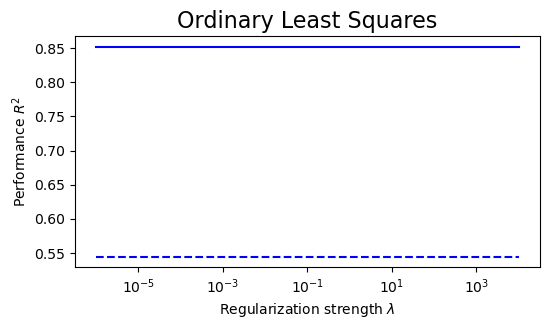

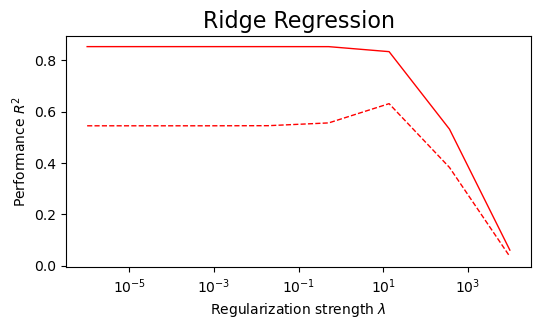

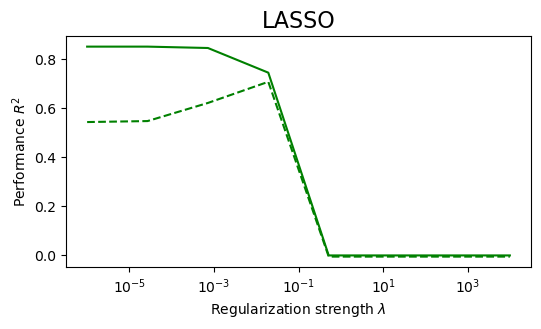

In [239]:
# Plot our performance on both the training and test data
plt.figure(figsize=(6, 3))
plt.semilogx(lambdas, train_error_ols, "b", label="Train (OLS)")
plt.semilogx(lambdas, test_error_ols, "--b", label="Test (OLS)")
plt.title("Ordinary Least Squares", fontsize=16)
plt.xlabel("Regularization strength $\lambda$")
plt.ylabel("Performance $R^2$")


plt.figure(figsize=(6, 3))
plt.semilogx(lambdas, train_error_l2, "r", label="Train (Ridge)", linewidth=1)
plt.semilogx(lambdas, test_error_l2, "--r", label="Test (Ridge)", linewidth=1)
plt.title("Ridge Regression", fontsize=16)
plt.xlabel("Regularization strength $\lambda$")
plt.ylabel("Performance $R^2$")

plt.figure(figsize=(6, 3))
plt.semilogx(lambdas, train_error_l1, "g", label="Train (LASSO)")
plt.semilogx(lambdas, test_error_l1, "--g", label="Test (LASSO)")
plt.title("LASSO", fontsize=16)
plt.xlabel("Regularization strength $\lambda$")
plt.ylabel("Performance $R^2$")


It looks like the highest test error occurred at an intermediate value of $\lambda$. This is a common phenomenon in machine learning: the model is so unconstrained at low $\lambda$ that it overfits the training data, while at high $\lambda$ the model is so constrained that it underfits the data, missing important features.

In [141]:
lambda_optimal = lambdas[np.argmax(test_error_l1)]
print("Optimal lambda for Lasso: ", lambda_optimal)

Optimal lambda for Lasso:  0.019306977288832496


Text(0.5, 1.0, 'Difference between true and predicted values')

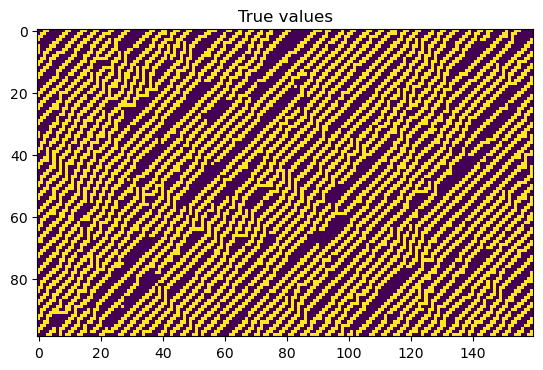

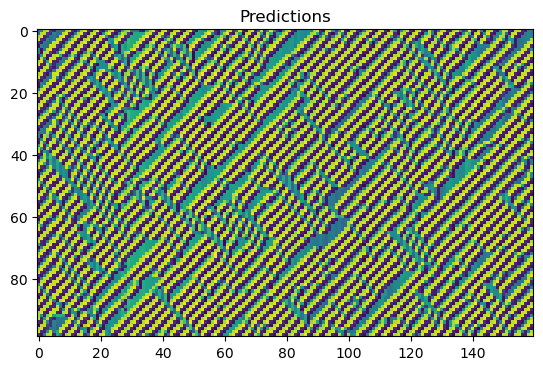

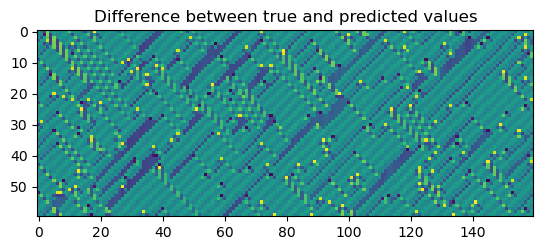

In [150]:
model_l1.set_params(alpha=lambda_optimal)
model_l1.fit(X_train, y_train)

y_pred_test = model_l1.predict(X_test)

plt.figure()
plt.imshow(y_test[:100])
plt.title("True values")

plt.figure()
plt.imshow(y_pred_test[:100])
plt.title("Predictions")

# plt.figure()
# plt.imshow(np.round(y_pred_test[:100]))
# plt.title("Rounded Predictions")

plt.figure()
plt.imshow(y_test[-60:] - y_pred_test[-60:])
plt.title("Difference between true and predicted values")

Let's take a look at the learned coupling matrix

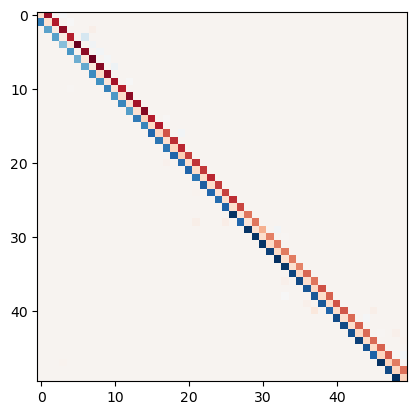

In [ ]:
plt.imshow(model_l1.coef_[:50, :50], cmap='RdBu_r')

## What physics do we learn from the dynamics matrix?

When we perform linear regression, we learn a matrix $A$ that maps the dynamics of the spins from one time step to the next.

$$
\mathbf{s}_{i + 1} = A \cdot \mathbf{s}_{i}
$$
where $\mathbf{s}_{i} \in \mathbb{R}^{L}$ is the state of the spins at time $i$, and $A \in \mathbb{R}^{L \times L}$ is the learned matrix.

Recall that when we discretized PDEs, a banded matrix indicated local spatial interactions, like the Laplacian acting on a lattice. We therefore expect that the banded structure of the matrix $A$ suggests that the spins are interacting with their nearest neighbors. 

The accuracy of the linear fit also suggests that the dynamics are indeed Markovian, and that the state of the spins at time $i$ is sufficient to predict the state of the spins at time $i+1$. If we suspected that this wasn't the case, we would instead fit a higher-order model,

$$
\mathbf{s}_{i + 1} = A \cdot \mathbf{s}_{i} + B \cdot \mathbf{s}_{i-1}
$$
where $B$ is another matrix of weights. This would allow the spins to depend on their state at the previous two time steps, and so on. We could alternatively change the shape of our training data, by concatenating the spins at multiple time steps into a single feature vector,

$$
\mathbf{s}_{i + 1} = A \cdot \text{vec}(\mathbf{s}_{i}, \mathbf{s}_{i-1})
$$

where $\text{vec}(\mathbf{s}_{i}, \mathbf{s}_{i-1}) \in \mathbb{R}^{2L}$ is the concatenation of the spins at times $i$ and $i-1$.

In [153]:
ca.powers

array([1, 2, 4])

In [ ]:
ca.ruleset


array([0, 1, 1, 1, 0, 0, 0, 0])

# One-dimensional cellular automata

+ It turns out our experimental data was generated from a noisy simulation of a one-dimensional cellular automaton

+ Recall that a one-dimensional cellular automaton is a discrete dynamical system that evolves a discrete lattice of cells in discrete time steps. Each cell can be in one of $N$ states, and the state of each cell at time $t$ is determined by the states of its neighbors at time $t-1$ according to a rule.

+ We can see that our cellular automaton had two states per cell and an update radius of $3$, meaning that each cell state updated based on the states of itself and its two nearest neighbors

+ The dynamical rule for a cellular automaton can be specified by a lookup table that gives the state of the cell for each possible binary string denoting the configurations of its neighbors. In our case, there are $2^3 = 8$ possible configurations of the cell and its two neighbors, so the lookup table has $2^3 = 8$ entries.

The lookup table is essentially a Boolean function, which takes in the binary string of the cell and its two neighbors and returns the state of the cell at the next time step. For our particular cellular automaton, the lookup table is

```
000 -> 0
001 -> 1
010 -> 1
011 -> 1
100 -> 0
101 -> 0
110 -> 0
111 -> 0
```

What happens if we instead have data from a cellular automaton with a different lookup table? Here's a very similar cellular automaton with a different lookup table. This is a well-known cellular automaton called Rule 30:

```
000 -> 0
001 -> 1
010 -> 1
011 -> 1
100 -> 1
101 -> 0
110 -> 0
111 -> 0
```








X_all shape:  (499, 50)
y_all shape:  (499, 50) 

X_train shape:  (400, 50)
y_train shape:  (400, 50) 

X_test shape:  (99, 50)
y_test shape:  (99, 50)


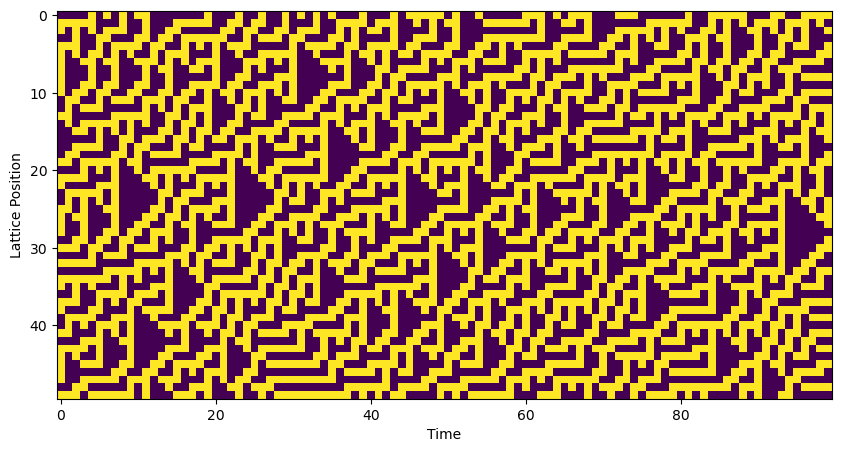

In [243]:
microstates = np.load('../resources/rule30_microstates.npy', allow_pickle=True)[:500]
plt.figure(figsize=(10, 30))
plt.imshow(microstates.T[:, :100])
plt.ylabel("Lattice Position")
plt.xlabel("Time")

X_all, y_all = microstates.copy()[:-1], microstates.copy()[1:]
print("X_all shape: ", X_all.shape)
print("y_all shape: ", y_all.shape, "\n")

# Data matrix / design matrix always has shape (n_samples, n_features)
X_train, X_test = X_all[:400], X_all[400:]
y_train, y_test = y_all[:400], y_all[400:]
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape, "\n")
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

R^2 score on training data:  0.001774999999999971
R^2 score on test data:  -0.0011755948469776012


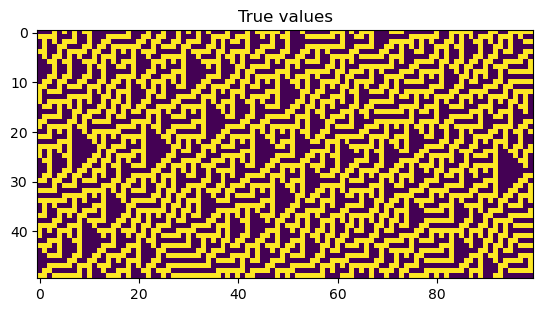

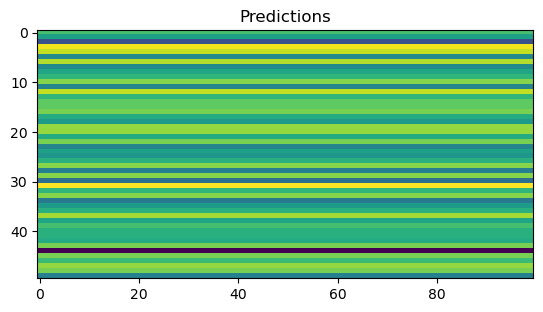

In [244]:
from sklearn.linear_model import Lasso

model = Lasso()
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

plt.figure()
plt.imshow(y_train[:100].T)
plt.title("True values")

plt.figure()
plt.imshow(y_pred_train[:100].T)
plt.title("Predictions")

print("R^2 score on training data: ", coefficient_of_determination(y_train, y_pred_train))
print("R^2 score on test data: ", coefficient_of_determination(y_test, y_pred_test))


# What can't our model fit?

+ We know that the generating process of our data is a one-dimensional cellular automaton, so it should be Markovian

$$
\mathbf{s}_{i + 1} = f(\mathbf{s}_{i})
$$

+ But what if the linear function class isn't expressive enough to capture the dynamics of the cellular automaton?

$$
\mathbf{s}_{i + 1} \neq A \cdot \mathbf{s}_{i}
$$

+ How could we generalize our model to capture more complex dynamics?

## Can we add additional free parameters into our model?

Linear regression:

$$
    \mathbf{s}_{i + 1} \neq A \cdot \mathbf{s}_{i}
$$

+ The weight matrix is constrained by our input size. $\mathbf{A} \in \mathbb{R}^{L \times L}$ because our inputs (microstates) are on an $L$ lattice, and so we had $L^2$ free parameters

##### Idea: 

$$
\mathbf{s}_{i + 1} = \mathbf{B} \cdot \mathbf{C} \cdot \mathbf{s}_{i}
$$

where $\mathbf{B} \in \mathbb{R}^{L \times p}$ and $\mathbf{C} \in \mathbb{R}^{p \times L}$, with $p$ being a hyperparameter that controls the complexity of the model. This "hidden" or "latent" dimensionality allows us to have a more complex model.

However, the problem is that $\mathbf{B} \cdot \mathbf{C} \equiv \mathbf{A}\in \mathbb{R}^{40 \times 40}$, so we don't gain any expressivity

### Solution:

$$
\mathbf{s}_{i + 1} = \mathbf{B} \cdot \sigma(\mathbf{C} \cdot \mathbf{s}_{i})
$$

where $\sigma(.)$ is an elementwise nonlinear function, like $\tanh(.)$. Now the model doesn't collapse, so we have $2 \times L \times p$ free parameters as well as the ability to capture nonlinear relationships among the spins

This is a one-layer neural network, with a $p$ unit "hidden" layer. We can always go wider or deeper to further increase the model complexity.

R^2 score on training data:  0.8953384649747517


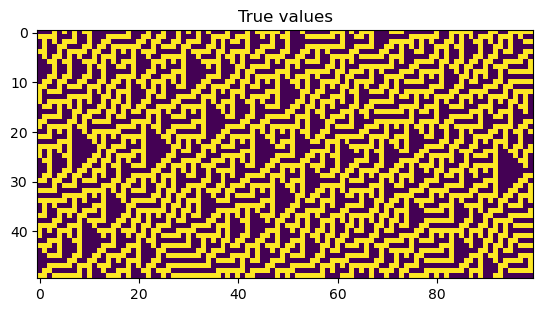

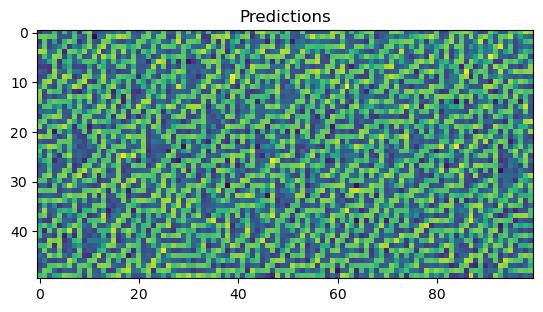

In [253]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=(200), activation='logistic', 
                     max_iter=2000, learning_rate_init=0.01, random_state=0)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

plt.figure()
plt.imshow(y_train[:100].T)
plt.title("True values")

plt.figure()
plt.imshow(y_pred_train[:100].T)
plt.title("Predictions")

print("R^2 score on training data: ", coefficient_of_determination(y_train, y_pred_train))

### Hyperparameter tuning

We can imagine that an even more general model would have both regularizers, each with different strengths
$$
\mathcal{L}_{total} = \mathcal{L}_{least-squares} + \lambda_1 \mathcal{L}_{lasso} + \lambda_2 \mathcal{L}_{ridge}
$$
This loss function is sometimes referred to as least-squares with an ElasticNet penalty.


## Why not always use regularizers
+ The issue: we have two arbitrary factors, $\lambda_1$ and $\lambda_2$, which determine how important the L1 and L2 penalties are relative to the primary fitting. These change the available solution space and thus model class
+ These are not "fit" during training like ordinary parameters; rather they are specified beforehand, perhaps with a bit of intuition or domain knowledge, These therefore represent *hyperparameters* of the model
+ Generally speaking, any "choices" we make---amount of data, model type, model parameters, neural network depth, etc are all hyperparameters. How do we choose these in a principled manner?
+ A major question in machine learning: **How do we choose the best hyperparameters for a model?**



array([4, 1, 3, 0, 1])

## Validation set
+ Hold out some data just for hyperparameter tuning, separate from the test set
+ Don't validate on test, that leads to data leakage and thus overfitting

Best lambda on validation set 0.0005336699231206307


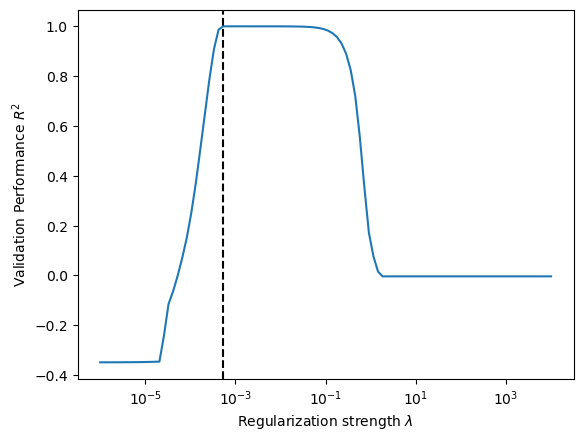

In [93]:
from sklearn import linear_model

# define train, validation and test data sets
X_train, X_val, X_test = X_all[:400], X_all[400 : 600], X_all[600 : 800]
y_train, y_val, y_test = y_all[:400], y_all[400 : 600], y_all[600 : 800]

# the hyperparameter values to check
lambdas = np.logspace(-6, 4, 100)

all_validation_losses = list()

for lam in lambdas:
    model_l1 = linear_model.Lasso(alpha=lam)
    model_l1.fit(X_train, y_train)
    validation_loss = model_l1.score(X_val, y_val)
    all_validation_losses.append(validation_loss)

best_lambda = lambdas[np.argmax(all_validation_losses)]

plt.semilogx(lambdas, all_validation_losses, label="Validation")
plt.axvline(best_lambda, color='k', linestyle='--', label="Best lambda")
plt.xlabel("Regularization strength $\lambda$")
plt.ylabel("Validation Performance $R^2$")

print("Best lambda on validation set", best_lambda)

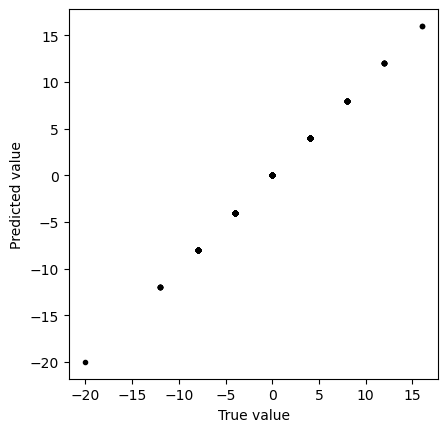

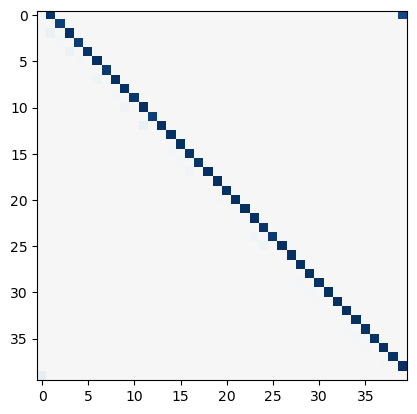

In [94]:
# fit best model 
model_l1 = linear_model.Lasso(alpha=best_lambda)
model_l1.fit(X_train, y_train)

y_test_predict = model_l1.predict(X_test)

plt.figure()
plt.plot(y_test, y_test_predict, ".k")
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.gca().set_aspect(1)


# plot Ising interaction J
J_lasso = np.array(model_l1.coef_).reshape((L, L))
plt.figure()
plt.imshow(J_lasso,  cmap="RdBu_r", vmin=-1, vmax=1)
plt.gca().set_aspect(1)

## Cross-validation

+ We repeatedly split-up the train into multiple sub-splits for training and validation
+ For example, if we have 100 train points, we can create five 80:20 "splits", and average the best hyperparameter across the splits
+ If we perform $k$ subsplits, we refer to our procedure as k-fold cross-validation
+ More elaborate splitting methods (random Monte Carlo, importance weighted, etc)


<img src="../resources/cross_val.png" alt="supervised_learning" style="width: 750px;"/>

Image from [source](https://towardsdatascience.com/cross-validation-k-fold-vs-monte-carlo-e54df2fc179b)

Best lambda on validation set 0.005623413251903491


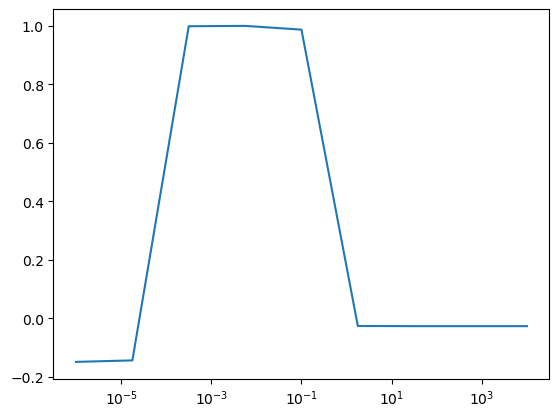

In [96]:
## Cross validation

from sklearn import linear_model

# define train, validation and test data sets
X_train, X_test = X_all[:600], X_all[600 : 800]
y_train, y_test = y_all[:600], y_all[600 : 800]

# the hyperparameter values to check
lambdas = np.logspace(-6, 4, 9)

all_validation_losses = list()

for lam in lambdas:

    all_val_loss_lam = list()

    for k in range(5):

        # Create the training and validation subsets from the training data
        X_train_k = np.concatenate([X_train[:k*100], X_train[(k+1)*100:]])
        y_train_k = np.concatenate([y_train[:k*100], y_train[(k+1)*100:]])
        X_val_k = X_train[k*100:(k+1)*100]
        y_val_k = y_train[k*100:(k+1)*100]


        model_l1 = linear_model.Lasso(alpha=lam)
        model_l1.fit(X_train_k, y_train_k)
        validation_loss = model_l1.score(X_val_k, y_val_k)
        all_val_loss_lam.append(validation_loss)

    all_validation_losses.append(np.mean(all_val_loss_lam))

best_lambda = lambdas[np.argmax(all_validation_losses)]
plt.figure()
plt.semilogx(lambdas, all_validation_losses, label="Validation")
print("Best lambda on validation set", best_lambda)

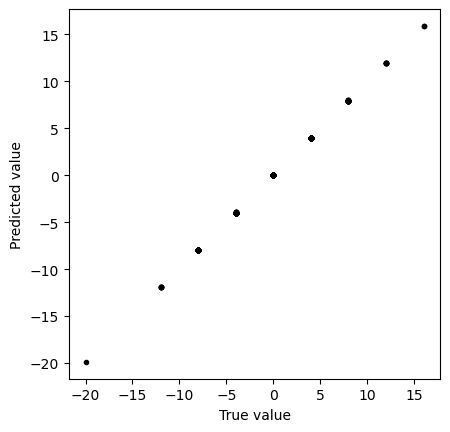

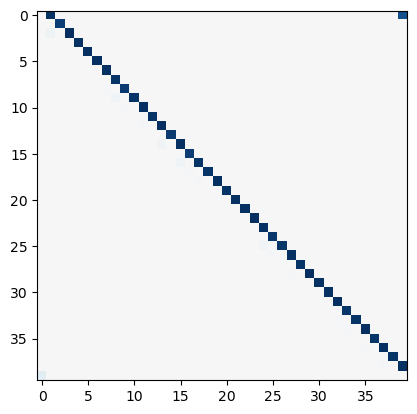

In [97]:
# fit best model 
model_l1 = linear_model.Lasso(alpha=best_lambda)
model_l1.fit(X_train, y_train)

y_test_predict = model_l1.predict(X_test)

plt.figure()
plt.plot(y_test, y_test_predict, ".k")
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.gca().set_aspect(1)


# plot Ising interaction J
J_lasso = np.array(model_l1.coef_).reshape((L, L))
plt.figure()
plt.imshow(J_lasso,  cmap="RdBu_r", vmin=-1, vmax=1)
plt.gca().set_aspect(1)

# Appendix

+ Build a programmatic CA model, which takes an instruction set in binary form and implements the corresponding neighborhood 3 cellular automaton.

+ Run this model for a few time steps, and visualize and save the results

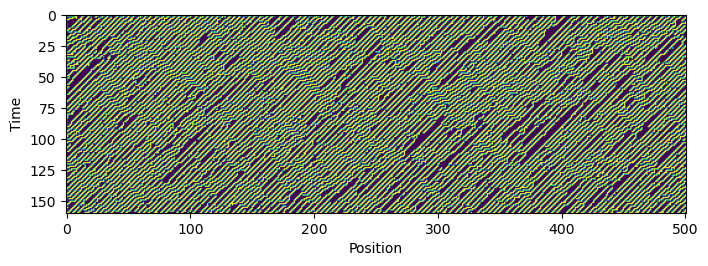

In [ ]:
class CellularAutomaton:
    """
    A base class for cellular automata. Subclasses must implement the step method.

    Parameters
        n (int): The number of cells in the system
        n_states (int): The number of states in the system
        mutation_rate (int): The number of spins that randomly flip at each time step
        random_state (None or int): The seed for the random number generator. If None,
            the random number generator is not seeded.
        initial_state (None or array): The initial state of the system. If None, a 
            random initial state is used.
        
    """
    def __init__(self, n, n_states, mutation_rate=0, random_state=None, initial_state=None):
        self.n_states = n_states
        self.mutation_rate = mutation_rate
        self.n = n
        self.random_state = random_state
        np.random.seed(random_state)

        ## The universe is a 2D array of integers
        if initial_state is None:
            self.initial_state = np.random.choice(self.n_states, size=self.n)
        else:
            self.initial_state = initial_state
        self.state = self.initial_state

        self.history = [self.state]

    def next_state(self):
        """
        Output the next state of the entire board
        """
        return NotImplementedError

    def simulate(self, n_steps):
        """
        Iterate the dynamics for n_steps, and return the results as an array
        """
        for i in range(n_steps):
            self.state = self.next_state()
            ## Add thermal noise
            flip_inds = np.random.choice(len(self.state), self.mutation_rate)
            self.state[flip_inds] = 1 - self.state[flip_inds]
            self.history.append(self.state.copy())
        return self.state
    

from scipy.ndimage import convolve1d

class ProgrammaticCA(CellularAutomaton):

    def __init__(self, n, ruleset,  **kwargs):
        k = np.unique(ruleset).size
        super().__init__(n, k, **kwargs)
        self.ruleset = ruleset

        ## A special convolutional kernel for converting a binary neighborhood 
        ## to an integer
        self.powers = 2 ** np.arange(3)


    def next_state(self):

        # Compute the next state
        next_state = np.zeros_like(self.state)
        
        # convolve with periodic boundary conditions
        rule_indices = convolve1d(self.state, self.powers, mode='wrap')

        ## look up the rule for each cell
        next_state = self.ruleset[rule_indices.astype(int)]

        return next_state


ruleset = np.array([0, 1, 1, 1, 0, 0, 0, 0]) # Rule good
ca = ProgrammaticCA(160, ruleset, mutation_rate=4, random_state=0)
ca.simulate(3001)

X_all = np.array(ca.history)

plt.figure(figsize=(8, 8))
plt.imshow(X_all.T[:, :501])
plt.xlabel("Position")
plt.ylabel("Time")

# X_all.dump('../resources/spin_chain_microstates.npy')

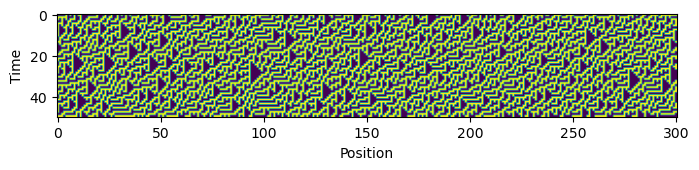

In [ ]:
ruleset = np.array([0, 1, 1, 1, 1, 0, 0, 0]) # Rule 30
ca = ProgrammaticCA(50, ruleset, mutation_rate=0, random_state=0)
ca.simulate(1001)

X_all = np.array(ca.history)

plt.figure(figsize=(8, 8))
plt.imshow(X_all.T[:, :301])
plt.xlabel("Position")
plt.ylabel("Time")

# X_all.dump('../resources/rule30_microstates.npy')

# One-dimensional cellular automata

+ A one-dimensional cellular automaton is a discrete dynamical system that evolves a discrete lattice of cells in discrete time steps. Each cell can be in one of $N$ states, and the state of each cell at time $t$ is determined by the states of its neighbors at time $t-1$ according to a rule.

+ For example, a neighborhood-3 cellular automaton has a rule that specifies the state of a cell based on the states of itself and its two neighbors. The rule can be specified by a lookup table that gives the state of the cell for each possible configuration of the neighborhood.

+ We've seen this code before; we implemented a "compiled" cellular automaton function in the genetic algorithms module


# One-dimensional cellular automata

+ We are going to consider one of the simplest possible physical systems: one-dimensional cellular automata

+ The update rule for a given 3 x 1 input can be though of as a Boolean truth table, which maps 3 Boolean values to 1 Boolean value. There are therefore $2^3 = 8$ possible inputs, and so a given 1D cellular automaton consists of a rule table of length $8$

+ How many possible unique 1D cellular automata are there? If each CA consists of $8$ rules, then the total number of cellular automata corresponds to all possible ways of assigning one of 2 possible output values to these $8$ rules. So the total number of possible 1D binary cellular autoamata corresponds to $2^{2^3} = 256$ possible cellular automata

+ On some level, we can think of there being $256$ possible physical laws in a purely discrete-time, discrete-space "universe," subject to the constraint that the field is constrained to have two possible values, and the "speed of information" is a maximum of one unit cell per time.

+ In the 1980s, Stephen Wolfram proposed a classification scheme for all $256$ cellular automata. For a given cellular automaton ruleset, we write the set of possible $3 x 1$ as a set of binary numbers. We sort these strings by their value when converted into base-10 integers:

xxx

We then write out the outputs that each string maps onto under the particular cellular automaton ruleset


We next interpret this as a binary integer of length 8


We conclude by converting this binary integer to base 10. For example, the representation above corresponds to "Rule 30". Every 1D cellular automaton therefore corresponds to a unique rule between 0 and 256







# Implementing one-dimensional binary cellular automata

+ To make the dynamics slightly more interesting, we will introduce noise into the system. Since the universe of CA consists only of binary values, noise correspond to random bit flips in the dynamics

# Learning a cellular automaton from data

+ We saw below how to generate XXX. We can see this as a vignette of the problems we've encountered so far in this course: We know the rules that govern a physical system, and we write code that implements those rules, or a close approximation

+ Often, however, we are interested in the inverse problem: We have experimental data, and we want to learn the physical rules that generated it.

+ Suppose that we are purely given a time series of cellular automaton states. Can we learn the rule directly from it? 

+ Our data consists of a time series consisting of $N_\text{data}$ timepoints. Because we want to learn the rules that generated this data, we will split it up into two groups a set of timepoints, and a set of timepoints that immediately follow them in the time series. We refer to these datasets as $X$ and $y$

+ We can think of the learning problem as inferring the unknown function $\mathbf{f}(.)$ such that $\mathbf{y} = \mathbf{f}(\mathbf{x})$

